# Importing Franke's function, including a plot

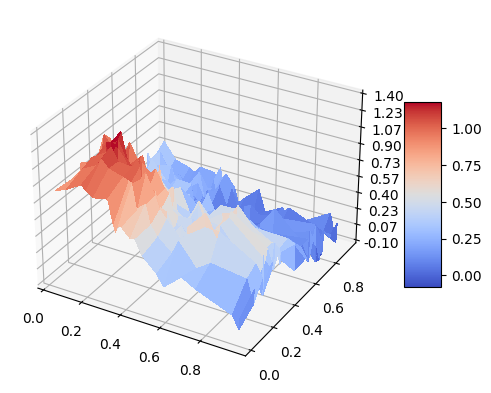

In [1]:
%reset -f

%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import pandas as pd

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Generate the data
n = 20 # number of data points
x = np.random.rand(n)
y = np.random.rand(n)
x = np.sort(x)
y = np.sort(y)

x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y) + 0.1*np.random.normal(0,1, x.shape)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [2]:
def rsquare(y, ypredict):
    y = y.reshape(-1, 1)
    ypredict = ypredict.reshape(-1,1)
    return 1-(np.sum((y-ypredict)**2)/np.sum((y-np.mean(y))**2))


def MSE(y_data,y_model):
    n = np.size(y_model)
    y_data = y_data.reshape(-1, 1)
    y_model = y_model.reshape(-1, 1)
    return np.sum((y_data-y_model)**2)/n

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/type_check.py:498: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = _nx.array(x, subok=True, copy=copy)


The optimal polynomial degree is 6 with a test MSE of 0.01255883167922045


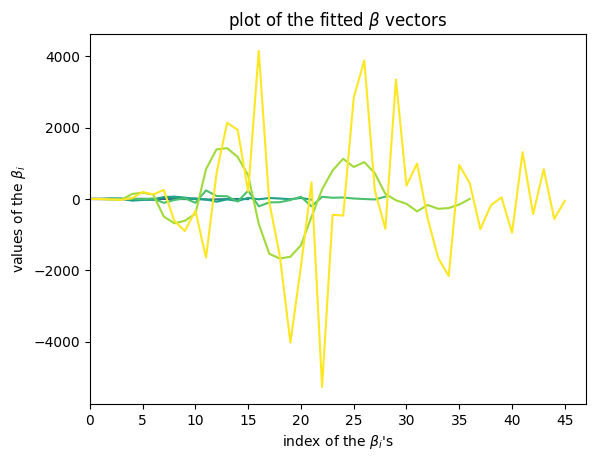

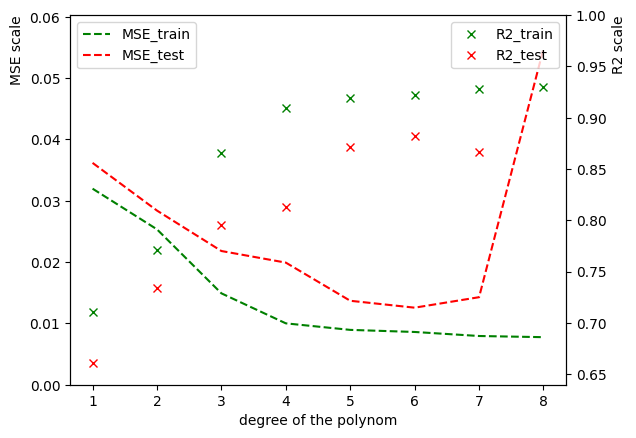

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import seaborn as sns

# max degree of the fitted polynomial
degree = 8

# setting up the Designmatrix
x = x.reshape(-1,1) #reshaping the meshgrid in two arrays
y = y.reshape(-1,1)
z = z.reshape(-1,1)

# credit: M. Hjorth-Jensen: Weekly Material, Week 35
def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

X = create_X(x,y,degree)

# splitting in train and test data
X_train, X_test, z_train, z_test = train_test_split( X, z, test_size=0.33, random_state=42)

# scaling the data, in this case we only center the data, thus we subtract the mean values from each column from every column entry
X_train_mean = np.mean(X_train,axis=0)
X_train_mean[0] = 0
X_train_scaled = X_train - X_train_mean
X_test_scaled = X_test - X_train_mean
# we now calculate our OLS model's intercept by using the expression from the lecture notes (M. Hjorth-Jensen: Notes on scaling with examples), which results from deriving the cost/loss function by beta0 and setting it to zero
# since our cost/loss function is convex this leads us to finding its minimum with respect to beta0
# The model intercept follows the equation z_scaler = np.mean(z_train) - np.mean(X_train_sc) * beta. Since we above centered our Designmatrix, the mean vector of X_train_sc equals the zero vector. Our equation reduces to:
z_scaler = np.mean(z_train)  
# We now center our z data
z_train_scaled = z_train - z_scaler
z_test_scaled = z_test - z_scaler


# OLS fitting

beta_list = []
MSE_train = np.zeros(degree)
MSE_test = np.zeros(degree)
rsqr_train = np.zeros(degree)
rsqr_test = np.zeros(degree)


for i in range(1, degree+1):
    c = int((i+2)*(i+1)/2)
    X_tilde = X_train_scaled[:,0:c]
    beta = np.linalg.pinv(X_tilde.T @ X_tilde) @ X_tilde.T @ z_train_scaled

    beta_list.append(list(beta))
		
    ypredict = X_tilde @ beta
    ypredict_test = X_test_scaled[:,0:c] @ beta

    MSE_train[i-1] = MSE(z_train_scaled, ypredict)
    MSE_test[i-1] = MSE(z_test_scaled, ypredict_test)
    rsqr_train[i-1]= rsquare(z_train_scaled, ypredict)
    rsqr_test[i-1]= rsquare(z_test_scaled, ypredict_test)

# plotting the MSE and R^2 - as well as beta - as functions of the polynomial degree
fig = plt.figure()

fig2, ax1 = plt.subplots()
plt.xlabel("degree of the polynom")
xax = np.arange(1, degree +1)
plt.xticks(xax)
ax2 = ax1.twinx()
ax2.set_ylim(np.min(rsqr_train)*0.9, 1)
ax1.set_ylim(0, np.max(MSE_test)*1.1)
ax1.plot(xax, MSE_train, 'g--', label='MSE_train')
ax1.plot(xax, MSE_test, 'r--', label='MSE_test')
ax2.plot(xax, rsqr_train, 'gx', label='R2_train')
ax2.plot(xax, rsqr_test, 'rx', label='R2_test')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.set_ylabel('MSE scale', loc='top')
ax2.set_ylabel('R2 scale', loc='top')

# plot the beta

fig3 = fig.subplots()
xax2 = np.arange(0, len(X)+2, 5)
fig3.set_xticks(xax2)
fig3.set_xlim(0, X.shape[1]+2)
beta_list = np.nan_to_num(beta_list)
colors = plt.cm.viridis(np.linspace(0, 1, degree))
for i in range(len(beta_list)):
	fig3.plot(np.append(z_scaler, beta_list[i]), color=colors[i])
fig3.set_ylabel("values of the " + r'$\beta_i$')
fig3.set_xlabel("index of the " + r'$\beta_i$' + "'s")
fig3.set_title("plot of the fitted " + r'$\beta$' + " vectors")

plt.savefig("abc_OLS.png")

MSE_opt_OLS , para_opt_OLS = MSE_test.min(), MSE_test.argmin()

print("The optimal polynomial degree is "+str(para_opt_OLS+1)+" with a test MSE of "+str(MSE_opt_OLS))

In [4]:
## TESTING OLS

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import linear_model

MSE_train_scikit = np.zeros(degree)
MSE_test_scikit = np.zeros(degree)

for i in range(1, degree+1):
        xx = X_train[:,[1, 2]]
        poly = PolynomialFeatures(degree=i)
        # creating the designmatrix from the vectors x, y
        designmatrix = poly.fit_transform(xx)
        OLS_scikit = LinearRegression(fit_intercept=False)
        OLS_scikit.fit(designmatrix, z_train)

        ypredict_OLS_scikit = OLS_scikit.predict(designmatrix)
        ypredict_test_OLS_scikit = OLS_scikit.predict(poly.fit_transform(X_test[:,[1, 2]]))

        MSE_train_scikit[i-1] = MSE(z_train, ypredict_OLS_scikit)
        MSE_test_scikit[i-1] = MSE(z_test, ypredict_test_OLS_scikit)


diff = MSE_train_scikit - MSE_train
diff2 = MSE_test_scikit - MSE_test

# b) Ridge regression

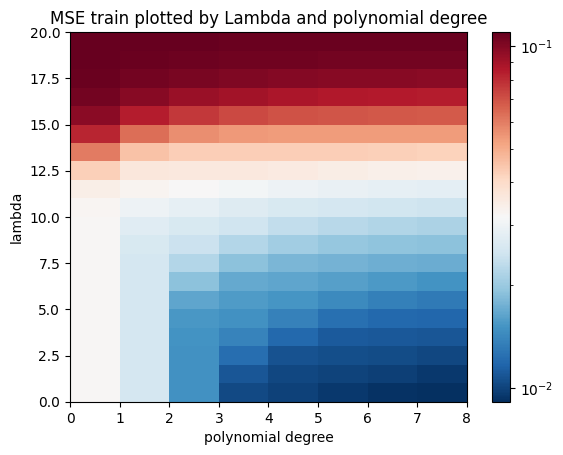

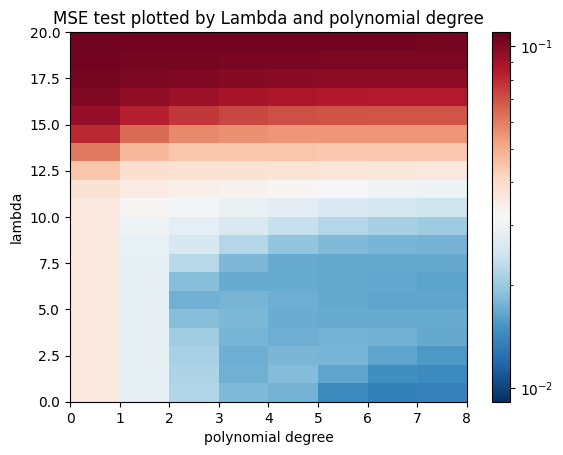

The optimal parameters are [lambda, polynomial degree] = [0.0001, 7] with a test MSE of 0.013457464253821964


In [5]:
# We are using the same data, as well as splitting, as in a). This allows us a better comparison between our results from the OLS and the Ridge fitting.

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

lmb = np.logspace(-4, 4, 20) 

MSE_train_Ridge = np.zeros((len(lmb),degree))
MSE_test_Ridge = np.zeros((len(lmb),degree))
rsqr_train_Ridge = np.zeros((len(lmb),degree))
rsqr_test_Ridge = np.zeros((len(lmb),degree))

beta_Ridge = []

for j in range(len(lmb)):
    for i in range(1, degree+1):
            c = int((i+2)*(i+1)/2)
            X_tilde = X_train_scaled[:,0:c]
            beta = np.linalg.pinv(X_tilde.T @ X_tilde + lmb[j]*np.eye(len(X_tilde.T))) @ X_tilde.T @ z_train_scaled
            
            beta_Ridge.append(beta)

            ypredict = X_tilde @ beta
            ypredict_test = X_test_scaled[:,0:c] @ beta

            MSE_train_Ridge[j, i-1] = MSE(z_train_scaled, ypredict)
            MSE_test_Ridge[j, i-1] = MSE(z_test_scaled, ypredict_test)
            rsqr_train_Ridge[j, i-1]= rsquare(z_train_scaled, ypredict)
            rsqr_test_Ridge[j, i-1]= rsquare(z_test_scaled, ypredict_test)


# plotting the MSEs as functions of the polynomial degree
fig, ax = plt.subplots()
minimum = [MSE_test_Ridge.min(), MSE_train_Ridge.min()]
min = np.min(minimum)
maximum = [MSE_test_Ridge.max(), MSE_train_Ridge.max()]
max = np.max(maximum)
norm=colors.LogNorm(vmin=min, vmax=max)
ax.pcolormesh(MSE_train_Ridge, cmap='RdBu_r', norm=norm)
plt.xticks()
plt.title("MSE train plotted by Lambda and polynomial degree")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='RdBu_r'), ax=ax)
plt.xlabel("polynomial degree")
plt.ylabel("lambda")
plt.show()

fig, ax = plt.subplots()
ax.pcolormesh(MSE_test_Ridge, cmap='RdBu_r', norm=norm)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='RdBu_r'), ax=ax)
plt.xlabel("polynomial degree")
plt.ylabel("lambda")
plt.title("MSE test plotted by Lambda and polynomial degree")
plt.show()

MSE_opt_Ridge, para_opt_Ridge = MSE_test_Ridge.min(), np.unravel_index(MSE_test_Ridge.argmin(), MSE_test_Ridge.shape)

print("The optimal parameters are [lambda, polynomial degree] = ["+str(lmb[para_opt_Ridge[0]])+", "+str(para_opt_Ridge[1]+1)+"]"+" with a test MSE of "+str(MSE_test_Ridge.min()))

In [6]:
## TESTING RIDGE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn import linear_model

MSE_train_Ridge_scikit = np.zeros((len(lmb),degree))
MSE_test_Ridge_scikit = np.zeros((len(lmb),degree))

beta_Ridge_scikit = []

for j in range(len(lmb)):
        for i in range(1, degree+1):
                xx_Ridge = X_train[:,[1, 2]]
                poly = PolynomialFeatures(degree=i)
                # creating the designmatrix from the vectors x, y
                designmatrix = poly.fit_transform(xx_Ridge)
                RegRidge_scikit = linear_model.Ridge(lmb[j], fit_intercept=True)
                RegRidge_scikit.fit(designmatrix, z_train)

                beta_Ridge_scikit.append(list(RegRidge_scikit.coef_))

                ypredict_Ridge_scikit = RegRidge_scikit.predict(designmatrix)
                ypredict_test_Ridge_scikit = RegRidge_scikit.predict(poly.fit_transform(X_test[:,[1, 2]]))

                MSE_train_Ridge_scikit[j, i-1] = MSE(z_train, ypredict_Ridge_scikit)
                MSE_test_Ridge_scikit[j, i-1] = MSE(z_test, ypredict_test_Ridge_scikit)


diff_Ridge = MSE_train_Ridge_scikit - MSE_train_Ridge
diff2_Ridge = MSE_test_Ridge_scikit - MSE_test_Ridge

# c) Lasso Regression

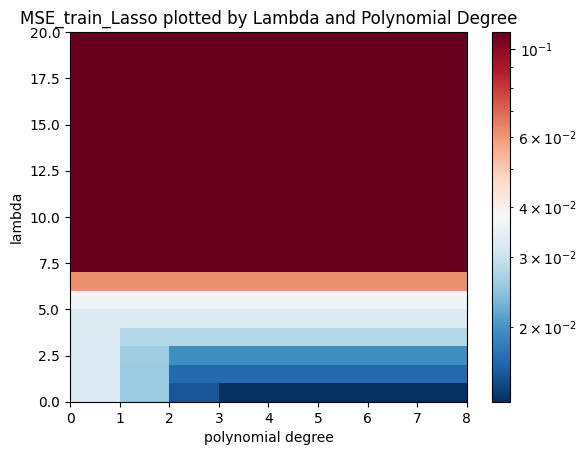

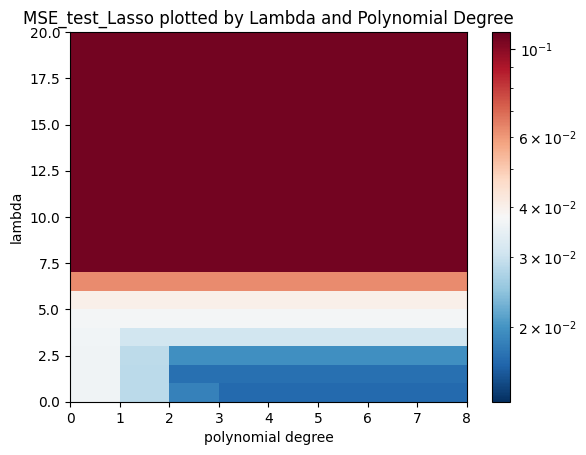

The optimal parameters are [lambda, polynomial degree] = [0.0001, 5] with a test MSE of 0.01638894061492349
0.012924117282377908 (0, 4)


In [7]:
from sklearn import linear_model
import numpy as np

MSE_train_Lasso = np.zeros((len(lmb),degree))
MSE_test_Lasso = np.zeros((len(lmb),degree))
rsqr_train_Lasso = np.zeros((len(lmb),degree))
rsqr_test_Lasso = np.zeros((len(lmb),degree))

X_tilde = X_train_scaled[:,[1, 2]]
# we can only fit the Lasso Reg without an intercept, when we can assure that the calculated intercept would equal zero, that's why we also scaled z above.

beta_Lasso = []

for i in range(1, degree+1):
    for j in range(len(lmb)):
        
        poly = PolynomialFeatures(degree=i)
        designmatrix = poly.fit_transform(X_tilde)
        RegLasso = linear_model.Lasso(lmb[j],fit_intercept=True)
        RegLasso.fit(designmatrix,z_train_scaled)

        beta_Lasso.append(RegLasso.coef_)

        ypredict_Lasso = RegLasso.predict(designmatrix)
        ypredict_test_Lasso = RegLasso.predict(poly.fit_transform(X_test_scaled[:,[1, 2]]))

        MSE_train_Lasso[j, i-1] = MSE(z_train_scaled, ypredict_Lasso)
        MSE_test_Lasso[j, i-1] = MSE(z_test_scaled, ypredict_test_Lasso)
        rsqr_train_Lasso[j, i-1] = MSE(z_train_scaled, ypredict_Lasso)
        rsqr_test_Lasso[j, i-1] = MSE(z_test_scaled, ypredict_test_Lasso)
        

# plotting the MSE and R^2 - as well as beta - as functions of the polynomial degree

fig, ax = plt.subplots()

minimum = [MSE_test_Lasso.min(), MSE_train_Lasso.min()]
min = np.min(minimum)
maximum = [MSE_test_Lasso.max(), MSE_train_Lasso.max()]
max = np.max(maximum)
norm=colors.LogNorm(vmin=min, vmax=max)
ax.pcolormesh(MSE_train_Lasso, cmap='RdBu_r', norm=norm)
plt.title("MSE_train_Lasso plotted by Lambda and Polynomial Degree")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='RdBu_r'), ax=ax)
plt.xlabel("polynomial degree")
plt.ylabel("lambda")
plt.show()

fig, ax = plt.subplots()
ax.pcolormesh(MSE_test_Lasso, cmap='RdBu_r', norm=norm)
plt.title("MSE_test_Lasso plotted by Lambda and Polynomial Degree")
fig.colorbar(cm.ScalarMappable(norm=norm, cmap='RdBu_r'), ax=ax)
plt.xlabel("polynomial degree")
plt.ylabel("lambda")
plt.show()

MSE_opt_Lasso, para_opt_Lasso = MSE_test_Lasso.min(), np.unravel_index(MSE_test_Lasso.argmin(), MSE_test_Lasso.shape)

MSE_mintrain_Lasso, para_mintrain_Lasso = MSE_train_Lasso.min(), np.unravel_index(MSE_train_Lasso.argmin(), MSE_train_Lasso.shape)

print("The optimal parameters are [lambda, polynomial degree] = ["+str(lmb[para_opt_Lasso[0]])+", "+str(para_opt_Lasso[1]+1)+"]"+" with a test MSE of "+str(MSE_test_Lasso.min()))

print(MSE_mintrain_Lasso, para_mintrain_Lasso)

Text(0, 1, 'MSE scale')

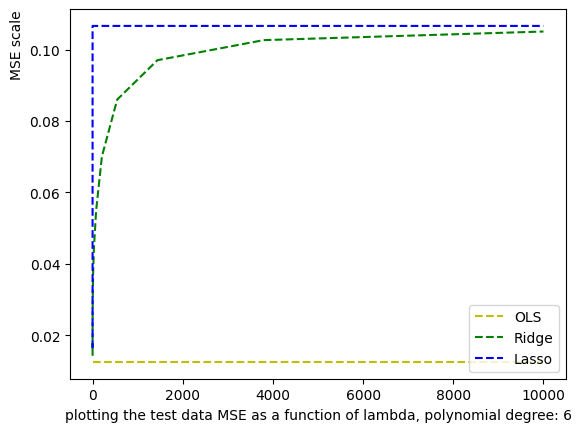

In [8]:
glob_min = np.min([MSE_opt_OLS, MSE_opt_Ridge, MSE_opt_Lasso])
glob_argmin = np.argmin([MSE_opt_OLS, MSE_opt_Ridge, MSE_opt_Lasso])

if glob_argmin == 0:
    para_opt = para_opt_OLS
elif glob_argmin == 1:
    para_opt = para_opt_Ridge[1]
elif glob_argmin == 2:
    para_opt = para_opt_Lasso[1]

plt.figure()
plt.xlabel("plotting the test data MSE as a function of lambda, polynomial degree: "+str(para_opt+1))
plt.plot(lmb, np.ones(len(lmb))*MSE_test[para_opt], 'y--', label='OLS')
plt.plot(lmb, MSE_test_Ridge[:, para_opt], 'g--', label='Ridge')
plt.plot(lmb, MSE_test_Lasso[:, para_opt], 'b--', label='Lasso')

plt.legend(loc='lower right')
plt.ylabel('MSE scale', loc='top')